# Group 2:利用TED_talk數據找到受大眾喜愛的影片類型與特徵以及預測觀看次數

<table><tr><td bgcolor=GhostWhite> 
<font color=#000000 size=3 face="黑體">
第二組：1106201張唯潁、1106203鄭云瑄、1116209黃紹瑋</font> 
     
<font color=#000000 size=3 face="粗黑體">TED Conference LLC. 是美國一家非營利組織，TED代表 「Technology （科技）,Entertainment （娛樂）,and  Design （設計）」</font> 
    
<font color=#000000 size=3 face="黑體">TED Talks的主題廣泛包含科技、娛樂、和設計，幾乎囊括了所有領域，在TED上的影片類型數量眾多，然而真正能引起觀眾興趣的演講內容卻相對較少，因此藉由數據分析來找尋怎樣類型的影片較受大眾喜愛，而演講者也可藉此找出受歡迎的演講者，是如何在影片中展現個人魅力來吸引觀眾眼球。</font> </td></tr></table>

          

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# pip install category_encoders
import category_encoders as ce

from sklearn.feature_selection import VarianceThreshold

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.ensemble import RandomForestClassifier
from numpy.core.umath_tests import inner1d
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE


In [2]:
# 定義函數以便執行肩並肩的列印
def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    print()
    return

 ## <span style='background:papayawhip'><font color=#000000 size=6 face="黑體">0. 資料引入及資料前處理</font></span>

<font color=#000000 size=4 face="黑體">首先引入在Kaggle上找到的TED TALK資料集</font>
<font color=#000000 size=3 face="黑體"><br>-資料來源網址https://www.kaggle.com/datasets/thegupta/ted-talk/discussion</font>

In [3]:
df = pd.read_csv('TED_talk.csv',low_memory=False)
df = df.loc[:, ~df.columns.str.contains('Unnamed')]
df.head(1)

,talk__id,talk__name,talk__description,view_count,comment_count,duration,transcript,video_type_name,event,number_of__speakers,...,related_talks,number_of__related_talks,intro_duration,ad_duration,post_ad_duration,external__duration,external__start_time,talks__player_talks__resources__h264__00__bitrate,talks__take_action,number_of__talks__take_actions
0,66,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,65678748,4952,1164,Good morning. How are you?(Audience) Good.It's...,TED Stage Talk,TED2006,1,...,"[{'id': '865', 'hero': 'https://pe.tedcdn.com/...",6,11.82,3.33,0.83,1204,0,180,[],0


###  資料處理，將太多空值的欄位以及有空值的資料行刪除

In [4]:
df.isnull().sum()

talk__id                                               17
talk__name                                             17
talk__description                                      17
view_count                                             19
comment_count                                        1161
duration                                               21
transcript                                            533
video_type_name                                        33
event                                                  33
number_of__speakers                                    48
speaker__id                                            44
speaker__name                                          34
speaker__description                                  632
speaker__who_he_is                                    571
speaker__why_listen                                  1033
speaker__what_others_say                             3191
speaker__is_published                                  45
all_speakers_d

In [5]:
#刪除太多空值的欄位
df.drop(columns=['speaker__what_others_say','has_talk_citation','url__webpage','url__audio','url__photo__talk',
                
                'url__photo__speaker','talk__more_resources','talk__recommendations__blurb','talk__recommendations',
                'talks__take_action','comment_count','speaker__why_listen','url__video','url__subtitled_videos',
                'talks__player_talks__resources__h264__00__bitrate','talk__description'], inplace=True)
#df.isnull().sum()

In [6]:
#刪除有空值的資料行
df = df.dropna()
df.shape

(3450, 36)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3450 entries, 0 to 4584
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   talk__id                             3450 non-null   object
 1   talk__name                           3450 non-null   object
 2   view_count                           3450 non-null   object
 3   duration                             3450 non-null   object
 4   transcript                           3450 non-null   object
 5   video_type_name                      3450 non-null   object
 6   event                                3450 non-null   object
 7   number_of__speakers                  3450 non-null   object
 8   speaker__id                          3450 non-null   object
 9   speaker__name                        3450 non-null   object
 10  speaker__description                 3450 non-null   object
 11  speaker__who_he_is                   3450 n

### **將資料都轉成一般常用的類型 : int、str等**

In [8]:
#df.info() #都是object

In [9]:
pd.set_option('display.max_columns', None)
df.head(1)

,talk__id,talk__name,view_count,duration,transcript,video_type_name,event,number_of__speakers,speaker__id,speaker__name,speaker__description,speaker__who_he_is,speaker__is_published,all_speakers_details,is_talk_featured,recording_date,published_timestamp,talks__tags,number_of__tags,language,native_language,language_swap,is_subtitle_required,number_of__subtitled_videos,talk__download_languages,number_of__talk__download_languages,number_of__talk__more_resources,number_of__talk__recommendations,related_talks,number_of__related_talks,intro_duration,ad_duration,post_ad_duration,external__duration,external__start_time,number_of__talks__take_actions
0,66,Do schools kill creativity?,65678748,1164,Good morning. How are you?(Audience) Good.It's...,TED Stage Talk,TED2006,1,69,Sir Ken Robinson,"Author, educator",Creativity expert Sir Ken Robinson challenges ...,1,"[{'id': '69', 'slug': 'sir_ken_robinson', 'is_...",TRUE,2006/2/25,2006/6/27 00:11,"['children', 'creativity', 'culture', 'dance',...",7,en,en,FALSE,FALSE,61,"[{'languageName': 'Portuguese, Brazilian', 'en...",62,3,1,"[{'id': '865', 'hero': 'https://pe.tedcdn.com/...",6,11.82,3.33,0.83,1204,0,0


In [10]:
col=['talk__id','view_count','duration','number_of__speakers','speaker__id','speaker__is_published',
    'number_of__tags','number_of__subtitled_videos','number_of__talk__download_languages',
    'number_of__talk__more_resources','number_of__talk__recommendations',
    'number_of__related_talks','intro_duration','ad_duration','post_ad_duration',
    'external__duration','external__start_time','number_of__talks__take_actions'
    ]

df[col] = df[col].apply(pd.to_numeric, errors='coerce')
#轉成合適的類型，object會變string、大多數float會轉int
df = df.convert_dtypes() 

In [11]:
#將時間類型欄位轉為時間格式
df['recording_date'] = pd.to_datetime(df['recording_date'], errors='coerce')
df['published_timestamp'] = pd.to_datetime(df['published_timestamp'], errors='coerce')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3450 entries, 0 to 4584
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   talk__id                             3450 non-null   Int64         
 1   talk__name                           3450 non-null   string        
 2   view_count                           3446 non-null   Int64         
 3   duration                             3446 non-null   Int64         
 4   transcript                           3450 non-null   string        
 5   video_type_name                      3450 non-null   string        
 6   event                                3450 non-null   string        
 7   number_of__speakers                  3394 non-null   Int64         
 8   speaker__id                          3394 non-null   Int64         
 9   speaker__name                        3450 non-null   string        
 10  speaker__des

In [13]:
print(df.shape)
df = df.dropna()
print(df.shape)

(3450, 36)
(3363, 36)


#### 在轉完格式之後會有些值變成缺漏值 將這些刪除之後我們會得到36個欄位以及3363筆資料

### 資料結果與描述

- **talk__name**:  影片標題
- **view_count**: 影片觀看數
- **duration**: 影片片長
- **transcript**: 影片逐字稿
- **video_type_name**: 影片類型名稱
- **even**: 活動名稱,代表演講影片是在某活動上演出
- **number_of__speakers**: 講者數量
- **speaker__name**: 講者名字
- **speaker__description**: 講者介紹
- **speaker__who_he_is**: 講者身分
- **speaker__is_published**: 講者是否有名氣
- **all_speakers_details**: 講者詳細資訊
- **is_talk_featured**: 演講議題   
- **published_timestamp**: 影片發布時間   
- **talks__tags**: 演講影片標籤  
- **number_of__tags**: 影片標籤數量
- **language**: 影片使用語言
- **native_language**: 講者母語
- **language_swap**: 演講是否非母語    
- **is_subtitle_required**: 是否需要副標題
- **number_of__subtitled_videos**: 相關副標題影片
- **talk__download_languages**: 影片可下載語言種類
- **number_of__talk__download_languages**: 影片可觀看語言種類數量
- **number_of__talk__more_resources**: 影片相關資源數量
- **number_of__talk__recommendations**: 影片評論
- **related_talks**: 相關影片
- **number_of__related_talks**: 相關影片數量
- **intro_duration**: 介紹詞時長
- **ad_duration**: 廣告時長
- **post_ad_duration**: 播放廣告的時長
- **external__duration**: 影片總長
- **external__start_time**: 開始時間
- **number_of__talks__take_actions**: 影片開始到開始演講時長

 ## <span style='background:papayawhip'><font color=#000000 size=6 face="黑體">1. 處理Y(view_count)</font></span>

### 在做過資料前處理之後，要先處理Y(view_count)
### 因此將view_count的分布畫出來，並轉為常態分佈，最後將其分為三類(view_count最小的類別為0，最大的類別為2)

C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:453: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges[:-1], name="edges"),
C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:454: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(np.diff(edges) * shrink, name="widths"),


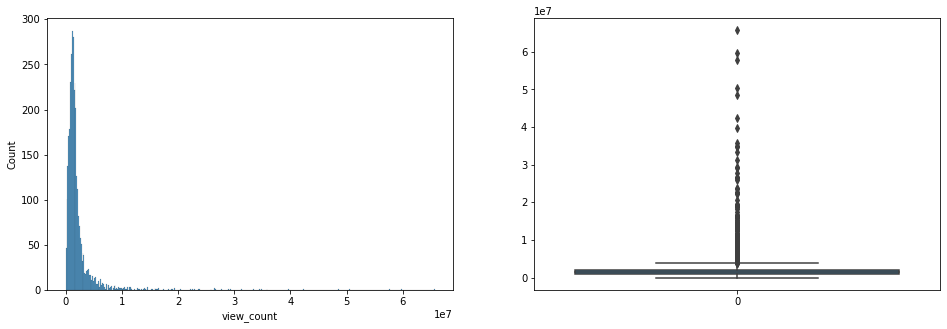

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (16,5))
sns.histplot(data = df['view_count'], ax=ax[0])
sns.boxplot(data = df['view_count'], ax=ax[1])

plt.show()

In [15]:
df['view_count'].describe()

count    3.363000e+03
mean     2.190071e+06
std      3.645211e+06
min      0.000000e+00
25%      9.367630e+05
50%      1.414560e+06
75%      2.122486e+06
max      6.567875e+07
Name: view_count, dtype: float64

### 刪去觀看次數為0的資料

In [16]:
df = df[df['view_count']!=0]

In [17]:
df['view_count'].describe()

count    3.358000e+03
mean     2.193332e+06
std      3.646943e+06
min      1.012400e+04
25%      9.390225e+05
50%      1.417073e+06
75%      2.122940e+06
max      6.567875e+07
Name: view_count, dtype: float64

### 轉換成常態分配

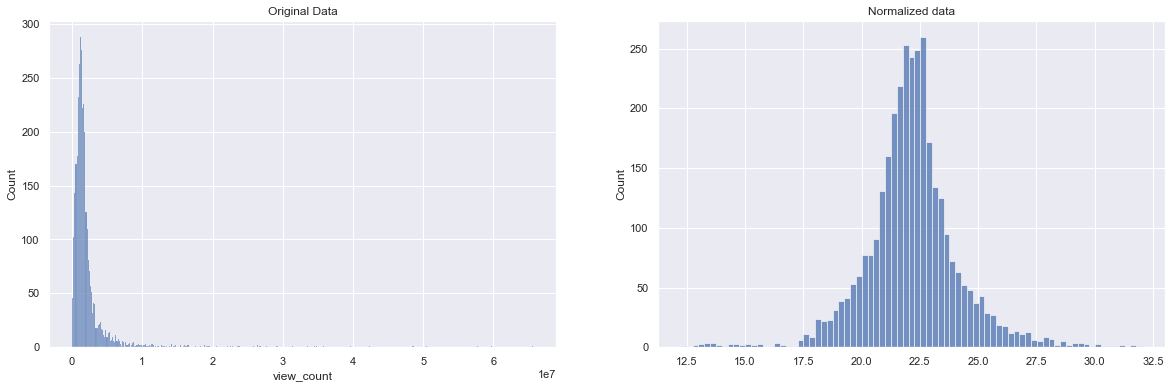

In [18]:
from scipy import stats
sns.set()
fig, ax = plt.subplots(1,2,figsize=(20,6))
df['view_count'] = df['view_count'].astype('float')
normalized_data = stats.boxcox(df['view_count'])[0] #轉為常態資料
# plot both together to compare
sns.histplot(df['view_count'], ax= ax[0])
ax[0].set_title("Original Data")
sns.histplot(normalized_data, ax=ax[1])
ax[1].set_title("Normalized data")
plt.show();

In [19]:
df['view_count'] = normalized_data
df['view_count'] = pd.cut(df['view_count'], 3, labels=np.arange(3)) #切成三等份
df['view_count'] = df['view_count'].astype('int')

In [20]:
df2= df.copy()

In [21]:
df2.shape

(3358, 36)

## <span style='background:papayawhip'><font color=#000000 size=6 face="黑體">2. Feature_Engineering: 將X轉成標籤類別型態</font></span>

In [22]:
df2.head(1)

,talk__id,talk__name,view_count,duration,transcript,video_type_name,event,number_of__speakers,speaker__id,speaker__name,speaker__description,speaker__who_he_is,speaker__is_published,all_speakers_details,is_talk_featured,recording_date,published_timestamp,talks__tags,number_of__tags,language,native_language,language_swap,is_subtitle_required,number_of__subtitled_videos,talk__download_languages,number_of__talk__download_languages,number_of__talk__more_resources,number_of__talk__recommendations,related_talks,number_of__related_talks,intro_duration,ad_duration,post_ad_duration,external__duration,external__start_time,number_of__talks__take_actions
0,66,Do schools kill creativity?,2,1164,Good morning. How are you?(Audience) Good.It's...,TED Stage Talk,TED2006,1,69,Sir Ken Robinson,"Author, educator",Creativity expert Sir Ken Robinson challenges ...,1,"[{'id': '69', 'slug': 'sir_ken_robinson', 'is_...",TRUE,2006-02-25,2006-06-27 00:11:00,"['children', 'creativity', 'culture', 'dance',...",7,en,en,FALSE,FALSE,61,"[{'languageName': 'Portuguese, Brazilian', 'en...",62,3,1,"[{'id': '865', 'hero': 'https://pe.tedcdn.com/...",6,11.82,3.33,0.83,1204.0,0.0,0.0


In [23]:
#刪去不適合用在此分析的資料
df2.drop(columns=['talk__id', 'transcript', 'speaker__name', 'speaker__description','speaker__who_he_is', 
                  'all_speakers_details','talks__tags', 'related_talks', 'talk__download_languages',
                 'recording_date','published_timestamp'], inplace=True)
df2.head(1)
#df2.shape
#df2.view_count

,talk__name,view_count,duration,video_type_name,event,number_of__speakers,speaker__id,speaker__is_published,is_talk_featured,number_of__tags,language,native_language,language_swap,is_subtitle_required,number_of__subtitled_videos,number_of__talk__download_languages,number_of__talk__more_resources,number_of__talk__recommendations,number_of__related_talks,intro_duration,ad_duration,post_ad_duration,external__duration,external__start_time,number_of__talks__take_actions
0,Do schools kill creativity?,2,1164,TED Stage Talk,TED2006,1,69,1,TRUE,7,en,en,FALSE,FALSE,61,62,3,1,6,11.82,3.33,0.83,1204.0,0.0,0.0


In [24]:
# 將需要轉數值的資料轉數值label
String_Features = df2.loc[:, df2.dtypes == 'string']
String_Features.columns

Index(['talk__name', 'video_type_name', 'event', 'is_talk_featured',
       'language', 'native_language', 'language_swap', 'is_subtitle_required'],
      dtype='object')

In [25]:
le = LabelEncoder()
for col in String_Features.columns: 
    df2[col] = le.fit_transform(df2[col])

In [26]:
#df2.head(3)
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
talk__name,3358.0,1678.500000,969.515429,0.0,839.25,1678.50,2517.75,3357.00
view_count,3358.0,1.011614,0.312841,0.0,1.00,1.00,1.00,2.00
duration,3358.0,780.591126,311.082102,60.0,566.00,791.00,999.00,2678.00
video_type_name,3358.0,4.199226,1.140648,0.0,4.00,4.00,4.00,6.00
event,3358.0,127.775462,105.104658,0.0,59.00,102.00,150.00,446.00
number_of__speakers,3358.0,1.032162,0.204599,1.0,1.00,1.00,1.00,5.00
speaker__id,3358.0,2813.932102,7144.836407,2.0,715.00,1637.00,3404.75,120686.00
speaker__is_published,3358.0,0.971709,0.165827,0.0,1.00,1.00,1.00,1.00
is_talk_featured,3358.0,0.958904,0.198542,0.0,1.00,1.00,1.00,1.00
number_of__tags,3358.0,7.866289,3.921594,1.0,5.00,7.00,10.00,33.00


#### 從上方的describe結果可以發現language、language_swap以及external__start_time的數值都為0,因此將這個欄位刪除 

In [27]:
#df2['language'].value_counts()
#df2['language_swap'].value_counts()
df2['external__start_time'].value_counts()

df2.drop(columns=['language','language_swap','external__start_time'], inplace=True)
df2.shape

(3358, 22)

## <span style='background:papayawhip'><font color=#000000 size=6 face="黑體">3. Feature_Selection: 選擇欄位</font></span>

選擇欄位有三個方法,我們將這三個方法應用並且取三個結果中有交集的欄位作為最終預測的X
- 過濾方法:....獨立檢定(必須先是normal(可以畫圖看)、或先轉成normal): Ki-square(類別vs類別)、F-test(類別vs數值) 
- wrapper
- embedded</font> 

### 3.1 過濾方法(Filter Methods)

### 基於方差閾值的方法(Variance-based Thresholding)

-因為需要同單位的欄位才可比較與計算，因此選擇了時間單位的欄位做檢測

-其中,'intro_duration','ad_duration','post_ad_duration','external__start_time','number_of__talks__take_actions'這幾個欄位的時間單位明顯相近,因此用time_feature變數作為一組檢測

-另外,'duration', 'external__duration'兩個欄位的時間單位相近,因此以time_feature2變數來做檢測

-**最後發現在時間單位的欄位中並沒有特別突出的特徵**

In [28]:
time_feature = df2[['view_count','intro_duration','ad_duration','post_ad_duration','number_of__talks__take_actions']].copy()
time_feature.head()

,view_count,intro_duration,ad_duration,post_ad_duration,number_of__talks__take_actions
0,2,11.82,3.33,0.83,0.0
1,2,11.82,3.33,0.83,0.0
2,2,11.82,3.33,0.83,0.0
3,2,11.82,3.33,0.83,0.0
4,2,11.82,3.33,0.83,0.0


In [29]:
time_feature2 = df2[['view_count','duration', 'external__duration']].copy()
time_feature2.head()

,view_count,duration,external__duration
0,2,1164,1204.0
1,2,588,589.0
2,2,1262,1263.0
3,2,1084,1115.0
4,2,1219,1250.0


In [30]:
#time_feature  #檢測
vt = VarianceThreshold(threshold=.5)
vt.fit(time_feature.iloc[:,:].to_numpy())
variance = pd.DataFrame({'variance': vt.variances_, 'select_feature': vt.get_support()}, index=time_feature.columns[:]).T
variance

,view_count,intro_duration,ad_duration,post_ad_duration,number_of__talks__take_actions
variance,0.09784,6.45256,0.512136,0.031817,0.499837
select_feature,False,True,True,False,False


In [31]:
#time_feature2  #檢測
vt = VarianceThreshold(threshold=.5)
vt.fit(time_feature2.iloc[:,:].to_numpy())
variance = pd.DataFrame({'variance': vt.variances_, 'select_feature': vt.get_support()}, index=time_feature2.columns[:]).T
variance

,view_count,duration,external__duration
variance,0.09784,96743.25599,115475.65449
select_feature,False,True,True


### 連續值和分類值之間的相關係數

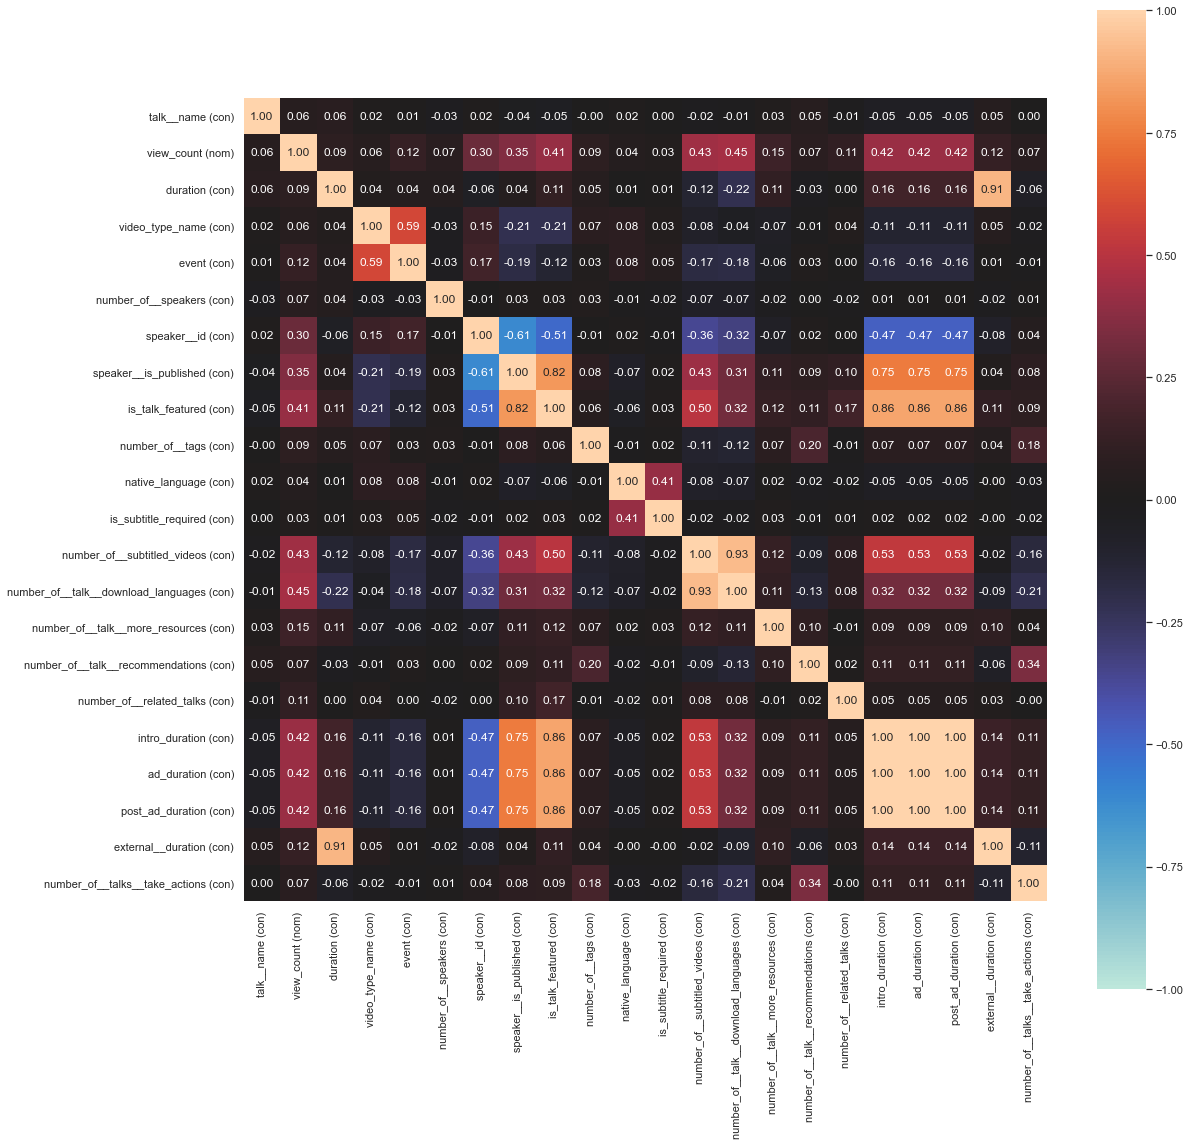

In [32]:
from dython import nominal
nominal.associations(df2, figsize=(18,18), nominal_columns='view_count',
                     mark_columns=True, nom_nom_assoc='cramer') # Cramer's V 
plt.show()

#### 刪除欄位 'ad_duration'、'post_ad_duration'
    -因 'ad_duration'、'post_ad_duration'與'intro_duration'一樣,相關係數為1

In [33]:
df2.drop(columns=['ad_duration','post_ad_duration'], inplace=True)
df2.shape

(3358, 20)

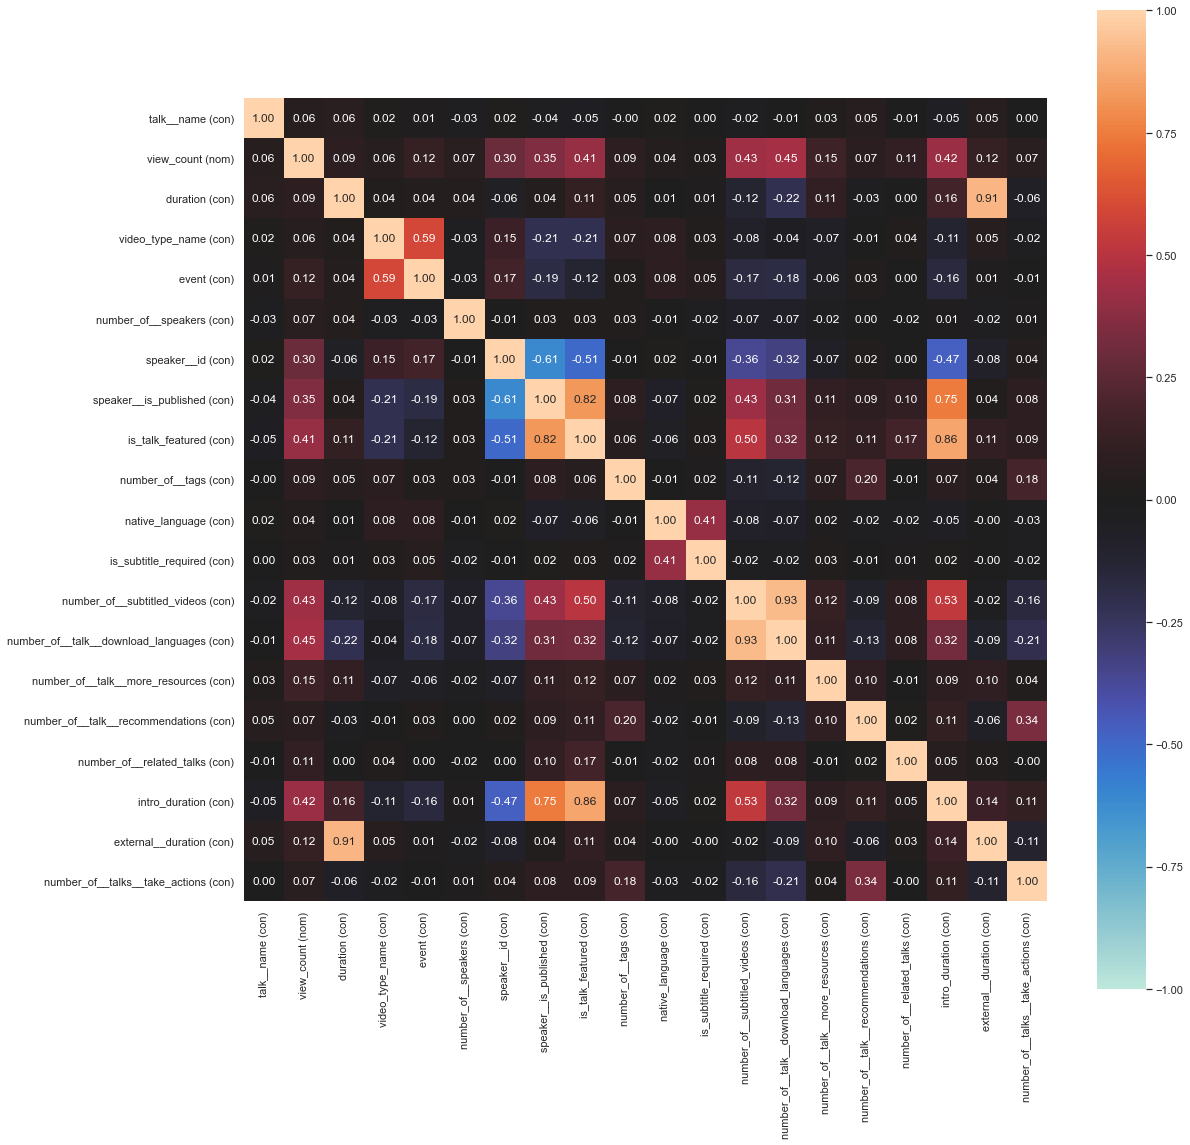

In [34]:
from dython import nominal
nominal.associations(df2, figsize=(18,18), nominal_columns='view_count',
                     mark_columns=True, nom_nom_assoc='cramer') # Cramer's V 
plt.show()

### 二元特徵的方差閾值方法(Binary Feature Variance Thresholding)

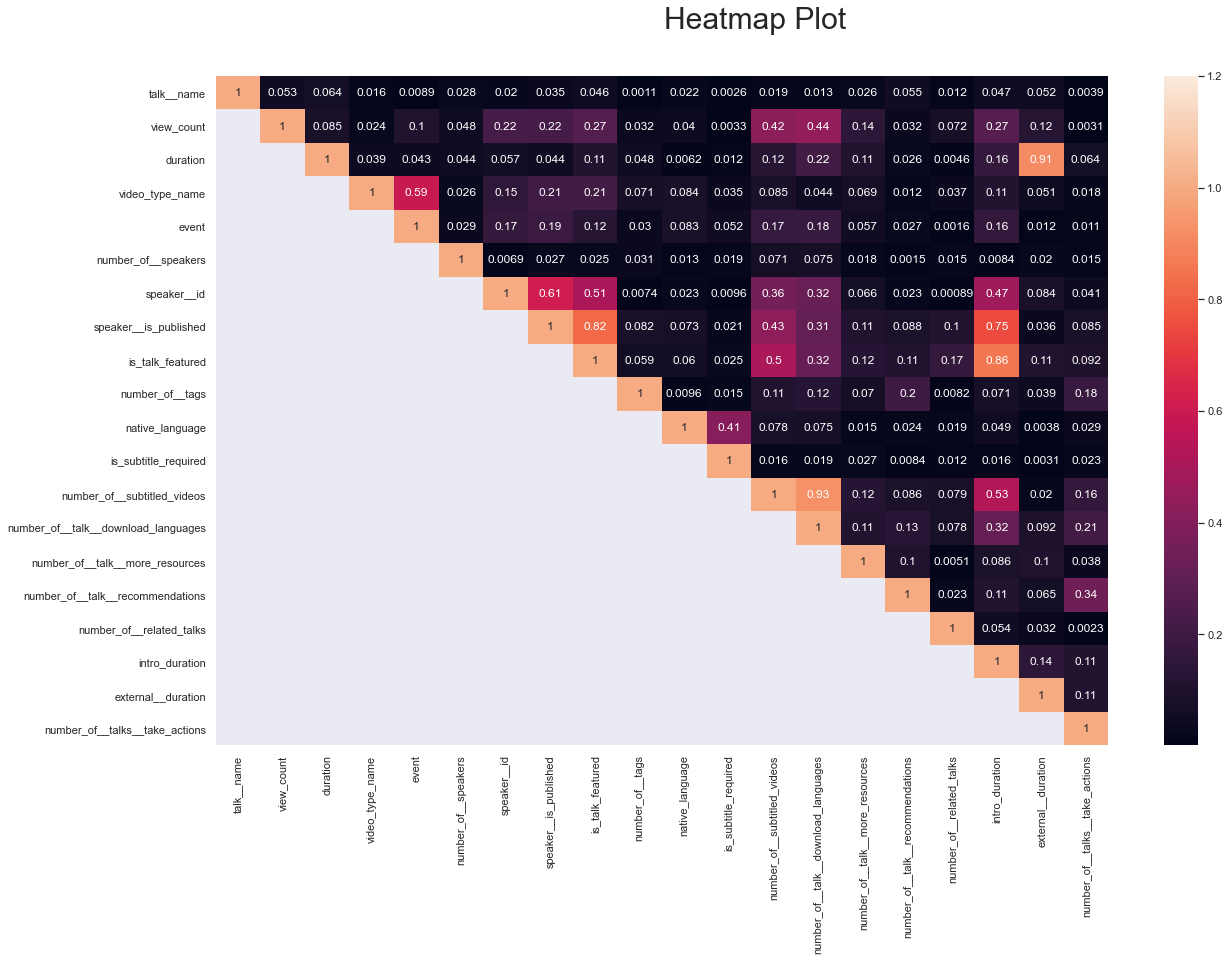

In [35]:
fig,ax = plt.subplots(figsize=(20,12))
fig.suptitle("Heatmap Plot", fontsize=30)
fig.subplots_adjust(top=0.9) 

corrcoef = abs(df2.corr())
mask = np.array(corrcoef)
mask[np.triu_indices_from(mask)] = False 

sns.heatmap(corrcoef, mask=mask, vmax=1.2, annot=True, ax=ax)

plt.show();

In [36]:
# 根據相關係數矩陣，創建上三角矩陣的列聯表(contingency table; two-way table)
upperTriangleDF = corrcoef.where(np.triu(np.ones(corrcoef.shape), k=1).astype(bool)) 
toDrop = [column for column in upperTriangleDF.columns[0:6] if any(upperTriangleDF[column] > 0.5)] 

# 拋棄與響應變數(應變數;目標變數)低相關的特徵
toDrop.append([ndx for ndx in upperTriangleDF['view_count'].index[0:6] 
               if upperTriangleDF['view_count'].at[ndx]< 0.1][0])
remainFeatureDF = upperTriangleDF.drop(toDrop, axis=1)
print("toDrop:\n", toDrop)
print("\nremainFeature:\n", remainFeatureDF.columns)

toDrop:
 ['event', 'talk__name']

remainFeature:
 Index(['view_count', 'duration', 'video_type_name', 'number_of__speakers',
       'speaker__id', 'speaker__is_published', 'is_talk_featured',
       'number_of__tags', 'native_language', 'is_subtitle_required',
       'number_of__subtitled_videos', 'number_of__talk__download_languages',
       'number_of__talk__more_resources', 'number_of__talk__recommendations',
       'number_of__related_talks', 'intro_duration', 'external__duration',
       'number_of__talks__take_actions'],
      dtype='object')


#### 根據此方法結果，刪除了'event', 'talk__name'兩個欄位

In [37]:
df2.drop(columns=['event', 'talk__name'], inplace=True)
df2.shape

(3358, 18)

### 3.2 包裝方法(Wrapper Methods)

### 遞廻式地減除特徵變量(Recursive Feature Elimination)

In [38]:
featureDF = df2.drop(columns=['view_count'])
targetDF = df2[['view_count']]

lr = LogisticRegression(solver='lbfgs', max_iter=8000) #5000會警告沒有收斂，增加迭代
#  step = 1, remove 1 feature each iteration. 
#  step within (0.0, 1.0), the percentage of features to remove at each iteration.
rfe_selector = RFE(estimator=lr, n_features_to_select=15, step=1) 

In [39]:
targetDF = targetDF.astype('float')

In [40]:
rfe_selector.fit(featureDF.to_numpy(), targetDF.to_numpy().ravel())
rfeSelectedFeaturesDF = featureDF[featureDF.columns[rfe_selector.get_support()]]
rfeSelectedFeaturesDF.sample(5)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,duration,video_type_name,number_of__speakers,speaker__is_published,is_talk_featured,number_of__tags,native_language,is_subtitle_required,number_of__subtitled_videos,number_of__talk__download_languages,number_of__talk__more_resources,number_of__talk__recommendations,number_of__related_talks,intro_duration,number_of__talks__take_actions
1431,722,2,1,1,1,10,1,0,20,20,0,1,6,11.82,1.0
3771,946,4,2,1,1,10,1,0,21,21,0,0,5,11.82,0.0
1880,1205,6,1,1,1,5,1,0,27,27,4,1,6,11.82,1.0
3708,679,6,1,1,1,7,1,0,17,17,1,0,6,11.82,0.0
4068,792,2,1,1,1,7,1,0,12,12,0,1,6,11.82,0.0


#### 印出遞廻式地減除特徵變量下所選擇的X欄位

In [41]:
print(set(featureDF.columns[rfe_selector.get_support()]))
#print(len(set(featureDF.columns[rfe_selector.get_support()])))

{'number_of__talks__take_actions', 'number_of__talk__recommendations', 'number_of__talk__download_languages', 'is_talk_featured', 'number_of__tags', 'number_of__speakers', 'speaker__is_published', 'native_language', 'video_type_name', 'is_subtitle_required', 'number_of__talk__more_resources', 'number_of__subtitled_videos', 'number_of__related_talks', 'duration', 'intro_duration'}


### 交叉驗證下的遞廻式地減除特徵變量(Recursive Feature Elimination with Cross Validation)

In [42]:
from sklearn.feature_selection import RFECV
lr = LogisticRegression(solver='lbfgs', max_iter=8000) #5000會警告沒有收斂，增加迭代
#  step = 1, remove 1 feature each iteration. 
#  step within (0.0, 1.0), the percentage of features to remove at each iteration.
rfecv_selector = RFECV(estimator=lr, min_features_to_select=15, cv=5, step=1) 
rfecv_selector.fit(featureDF.to_numpy(), targetDF.to_numpy().ravel())

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

RFECV(cv=5, estimator=LogisticRegression(max_iter=8000),
      min_features_to_select=15)

#### 印出交叉驗證下的遞廻式地減除特徵變量下所選擇的X欄位

In [43]:
print(set(featureDF.columns[rfecv_selector.support_]))
#print("There are %2d selected features" %featureDF[featureDF.columns[rfecv_selector.support_]].shape[1])

{'number_of__talks__take_actions', 'number_of__talk__recommendations', 'number_of__talk__download_languages', 'is_talk_featured', 'number_of__tags', 'number_of__speakers', 'speaker__is_published', 'native_language', 'video_type_name', 'external__duration', 'is_subtitle_required', 'number_of__talk__more_resources', 'number_of__subtitled_videos', 'number_of__related_talks', 'duration', 'intro_duration'}


### 3.3 嵌入式方法(Embedded or Model-based Methods) - 隨機森林(Random Forest)

In [44]:
rfClassifier = RandomForestClassifier()
rfClassifier.fit(featureDF.to_numpy(), targetDF.to_numpy().ravel())
RandomForestImportancesDF = pd.DataFrame(data = [rfClassifier.feature_importances_], 
                                     columns=featureDF.columns,
                                     index=["Importances"]).sort_values(by='Importances', axis=1, ascending=False)
RandomForestImportancesDF.iloc[0,0:15].index

Index(['number_of__talk__download_languages', 'speaker__id', 'duration',
       'external__duration', 'number_of__subtitled_videos', 'number_of__tags',
       'number_of__talk__more_resources', 'video_type_name',
       'number_of__talks__take_actions', 'intro_duration',
       'number_of__talk__recommendations', 'is_talk_featured',
       'speaker__is_published', 'number_of__speakers',
       'number_of__related_talks'],
      dtype='object')

### 將各個方法的選擇做交集統整,得到最終的特徵X欄位

In [45]:
# 各個方法所相同選擇的特徵變數列表
feature = \
set(featureDF.columns[rfe_selector.get_support()]) & \
set(featureDF.columns[rfecv_selector.support_]) & \
set(RandomForestImportancesDF.iloc[0,0:15].index)
feature

{'duration',
 'intro_duration',
 'is_talk_featured',
 'number_of__related_talks',
 'number_of__speakers',
 'number_of__subtitled_videos',
 'number_of__tags',
 'number_of__talk__download_languages',
 'number_of__talk__more_resources',
 'number_of__talk__recommendations',
 'number_of__talks__take_actions',
 'speaker__is_published',
 'video_type_name'}

In [46]:
df = df2[list(feature)]
df

,number_of__talks__take_actions,number_of__talk__recommendations,number_of__talk__download_languages,is_talk_featured,number_of__tags,number_of__speakers,speaker__is_published,video_type_name,number_of__talk__more_resources,number_of__subtitled_videos,number_of__related_talks,duration,intro_duration
0,0.0,1,62,1,7,1,1,4,3,61,6,1164,11.82
1,0.0,0,47,1,5,1,1,4,1,47,6,588,11.82
2,0.0,0,51,1,7,1,1,4,4,50,6,1262,11.82
3,0.0,1,48,1,5,1,1,6,1,47,6,1084,11.82
4,0.0,1,52,1,9,1,1,6,2,51,6,1219,11.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4358,0.0,0,2,0,5,1,0,6,0,0,6,747,0.0
4371,0.0,0,4,0,5,1,0,6,0,0,6,566,0.0
4388,0.0,0,3,0,3,1,0,2,0,0,3,662,0.0
4389,0.0,0,3,0,5,1,0,6,0,0,6,756,0.0


#### 我們取得這些方法皆挑出來的特徵，得到的欄位如下

- **duration**: 影片片長
- **intro_duration**: 介紹詞時長
- **is_talk_featured**: 演講議題  
- **number_of__related_talks**: 相關影片數量
- **number_of__speakers**: 講者數量
- **number_of__subtitled_videos**: 相關副標題影片
- **number_of__tags**: 影片標籤數量
- **number_of__talk__download_languages**: 影片可觀看語言種類數量
- **number_of__talk__more_resources**: 影片相關資源數量
- **number_of__talk__recommendations**: 影片評論
- **number_of__talks__take_actions**: 影片開始到開始演講時長
- **speaker__is_published**: 講者是否有名氣
- **video_type_name**: 影片類型名稱

In [47]:
df.head().T

,0,1,2,3,4
number_of__talks__take_actions,0.0,0.0,0.0,0.0,0.0
number_of__talk__recommendations,1,0,0,1,1
number_of__talk__download_languages,62,47,51,48,52
is_talk_featured,1,1,1,1,1
number_of__tags,7,5,7,5,9
number_of__speakers,1,1,1,1,1
speaker__is_published,1,1,1,1,1
video_type_name,4,4,4,6,6
number_of__talk__more_resources,3,1,4,1,2
number_of__subtitled_videos,61,47,50,47,51


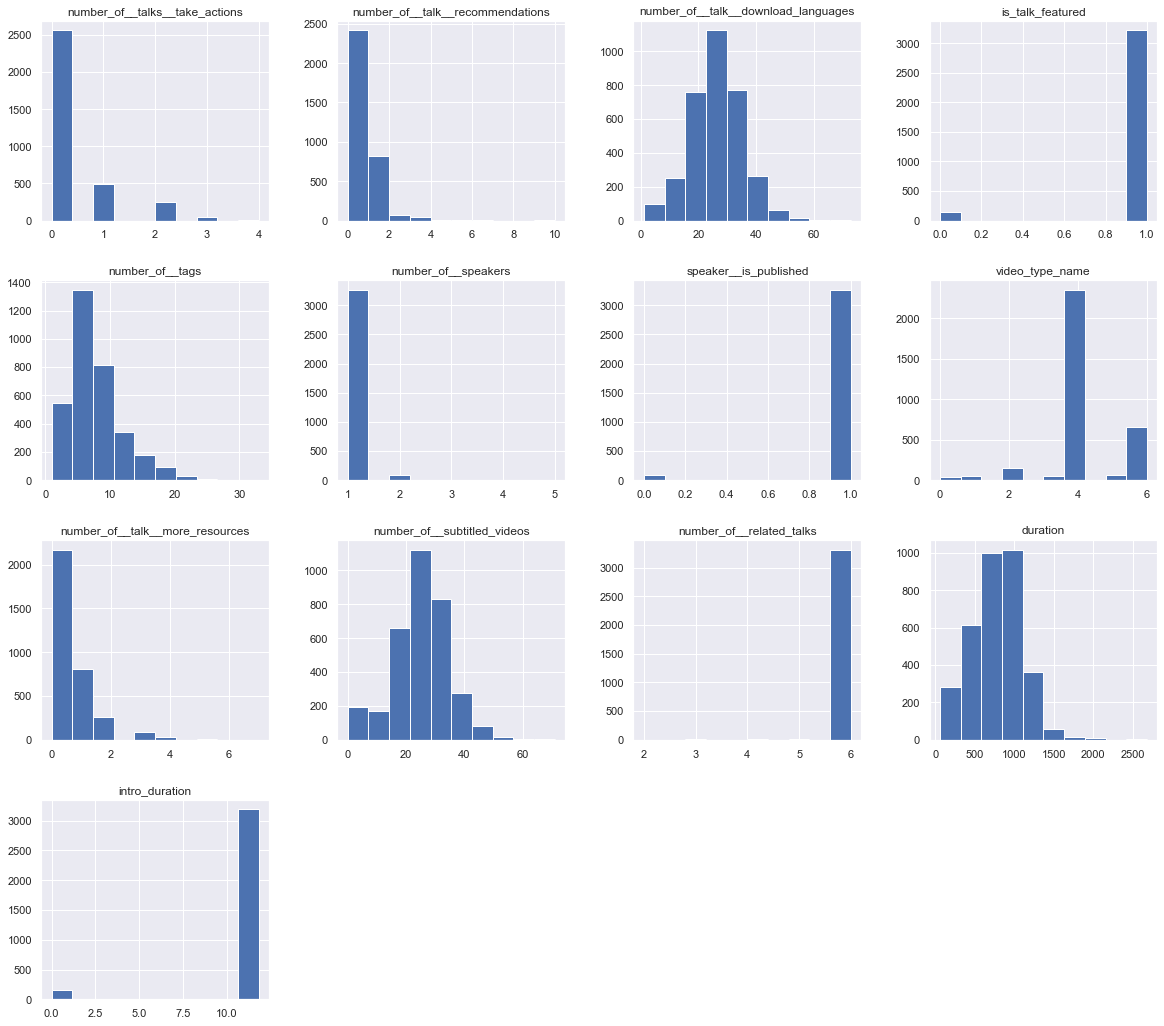

In [48]:
df.hist(figsize=(20,18))
plt.show()

## <span style='background:papayawhip'><font color=#000000 size=6 face="黑體">4. Modeling : 模型訓練</font></span>

### 首先我們先採用GaussianNB以及MultinomialNB兩個模型做訓練

In [49]:
df.head().T

,0,1,2,3,4
number_of__talks__take_actions,0.0,0.0,0.0,0.0,0.0
number_of__talk__recommendations,1,0,0,1,1
number_of__talk__download_languages,62,47,51,48,52
is_talk_featured,1,1,1,1,1
number_of__tags,7,5,7,5,9
number_of__speakers,1,1,1,1,1
speaker__is_published,1,1,1,1,1
video_type_name,4,4,4,6,6
number_of__talk__more_resources,3,1,4,1,2
number_of__subtitled_videos,61,47,50,47,51


In [50]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB 
NBclassifier = GaussianNB()
MNBclassifier = MultinomialNB()
from sklearn.model_selection import train_test_split
trainData, testData, trainTarget, testTarget = train_test_split(df, targetDF.values.ravel(), test_size=0.4, random_state=0)
NBclassifier.fit(trainData,trainTarget) # train 
MNBclassifier.fit(trainData,trainTarget) # train
side_by_side(trainData.shape, testData.shape, 
             NBclassifier.score(testData, testTarget), MNBclassifier.score(testData, testTarget)) # test 

(2014, 13)    (1344, 13)    0.8683035714285714    0.6383928571428571



### 但從結果來看 GaussianNB, MultinomialNB 效果都不好
### 下方我們用混淆矩陣來看模型的分類結果

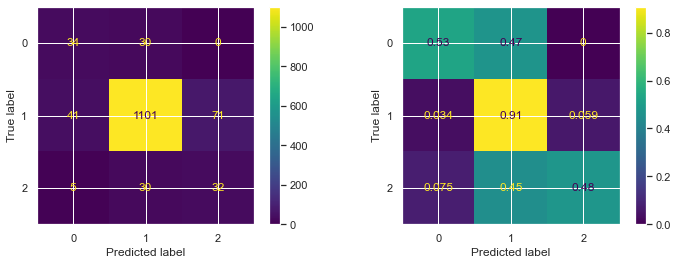

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
confusionMatrix = confusion_matrix(testTarget, NBclassifier.predict(testData), labels=NBclassifier.classes_)
confusionMatrix_norm = confusion_matrix(testTarget, NBclassifier.predict(testData), labels=NBclassifier.classes_, 
                                        normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ConfusionMatrixDisplay(confusion_matrix=confusionMatrix).plot(ax=ax[0])
ConfusionMatrixDisplay(confusion_matrix=confusionMatrix_norm).plot(ax=ax[1])
plt.show()

In [52]:
from sklearn.metrics import classification_report
# sklearn.metrics.classification_report(y_true, y_pred, ...)
print(classification_report(testTarget, NBclassifier.predict(testData), 
                            target_names=['View_Count_0', 'View_Count_1', 'View_Count_2']))
side_by_side('precision:', (confusionMatrix/confusionMatrix.sum(axis=0)).diagonal().reshape(-1,1), 
             'Recall:', (confusionMatrix/confusionMatrix.sum(axis=1)).diagonal().reshape(-1,1))

              precision    recall  f1-score   support

View_Count_0       0.42      0.53      0.47        64
View_Count_1       0.95      0.91      0.93      1213
View_Count_2       0.31      0.48      0.38        67

    accuracy                           0.87      1344
   macro avg       0.56      0.64      0.59      1344
weighted avg       0.89      0.87      0.88      1344

'precision:'    array([[0.425     ],     'Recall:'    array([[0.53125   ], 
                       [0.94832041],                         [0.90766694], 
                       [0.31067961]])                        [0.47761194]])



### 接著我們嘗試用SVM的模型做測試
- **並且利用ROC曲線以及曲線下的面積來做模型的效能評估**


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()
X = df
y = targetDF

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

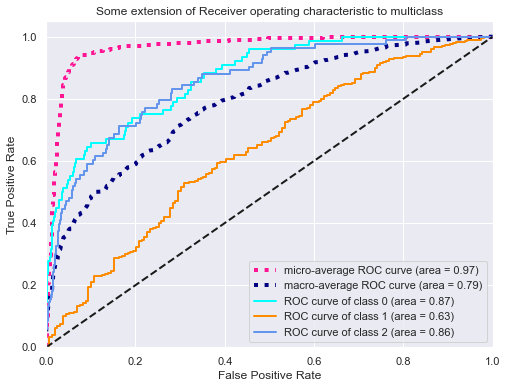

In [54]:
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (8,6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

#### SVM的成效中，view_count_0、view_count_2較view_count_1能被準確地分辨，AUC的面積相對較大

In [55]:
y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.787121 (macro),
0.656143 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.787121 (macro),
0.656143 (weighted by prevalence)


### 最後我們使用多種分類器去做測試

#### 定義分類器

In [56]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.mixture import GaussianMixture
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier

In [57]:
classiferNames = ["LogisticRegression", "Perceptron", "Naive Bayes",
                  "Linear Discriminant Analysis", "Quadratic Discriminant Analysis",
                  "Multi-layer Perceptron", 
                  # "Linear SVM", "RBF SVM",
                  "K-Nearest Neighbors Classifier",
                  "Decision Tree", "Random Forest", "AdaBoostClassifier",
                  "GradientBoostingClassifier"]

classifiers = [LogisticRegression(max_iter=5000), Perceptron(max_iter=1000, eta0=0.1, random_state=0), GaussianNB(), 
               LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(),
               MLPClassifier((100, 50), max_iter=2000, random_state=0), 
               # SVC(kernel='linear'), SVC(kernel='rbf', C=1),    
               KNeighborsClassifier(3),
               DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), AdaBoostClassifier(),
               GradientBoostingClassifier(max_depth=1)]

### 輸出訓練與測試的正確率

In [58]:
import warnings
warnings.simplefilter(action='ignore')
nameList= []
scoreList_Train=[]
scoreList_Test=[]
for aClassifier, aName in zip(classifiers, classiferNames):
    aClassifier.fit(trainData, trainTarget)
    nameList.append(aName)
    scoreList_Train.append(aClassifier.score(trainData, trainTarget).round(4))
    scoreList_Test.append(aClassifier.score(testData, testTarget).round(4))
    
trainedDF=pd.DataFrame(data = list(zip(nameList, scoreList_Train, scoreList_Test)), 
                       columns=['Name of Classifier', 'Training Score', 'Testing Score'])
trainedDF.sort_values("Training Score", axis = 0, ascending = False, inplace = True)
trainedDF.reset_index(drop=True,  inplace = True)
trainedDF['Diff%'] = np.round((trainedDF['Training Score']-trainedDF['Testing Score'])/trainedDF['Training Score'], 4)*100
trainedDF

,Name of Classifier,Training Score,Testing Score,Diff%
0,K-Nearest Neighbors Classifier,0.9255,0.9077,1.92
1,Decision Tree,0.9250,0.9107,1.55
2,GradientBoostingClassifier,0.9166,0.9167,-0.01
3,LogisticRegression,0.9156,0.9196,-0.44
4,Random Forest,0.9076,0.9122,-0.51
5,Perceptron,0.8992,0.8996,-0.04
6,Linear Discriminant Analysis,0.8992,0.9115,-1.37
7,Quadratic Discriminant Analysis,0.8779,0.8943,-1.87
8,Naive Bayes,0.8510,0.8683,-2.03
9,AdaBoostClassifier,0.7423,0.7560,-1.85


#### 在此結果中我們可以發現K-Nearest Neighbors Classifier有最高的Training Score,而在GradientBoostingClassifier以及LogisticRegression則有最好的Testing Score  
#### 因此就目前而言，K-Nearest Neighbors Classifier與GradientBoostingClassifier應該會是最適合我們資料的模型

## <span style='background:papayawhip'><font color=#000000 size=6 face="黑體">結論</font></span>

<table><tr><td bgcolor=GhostWhite><font color=#000000 size=3 face="黑體"><p align="left">在結論的部分，我們希望可以找到適合的模型來針對這個影片的可能觀看數量做預測，從結果來看，我們認為
<br>
<p align="left">1.在資料的前處理部分若用不一樣的方式可能會導致不一樣的結果，目前我們是直接將有空值的資料刪除
<br>
2.在特徵選取上是否將部分的欄位轉換成類別也可能影響最後的結果以及模型的訓練
<br>
3.在最後的多個分類器結果來看，訓練的分數以及測試的分數幾乎當相當的高，在訓練上有機會有過度擬合的問題，或是資料上可能有偏差，未來可以再做進一步的分析去解釋並找出原因</font> </td></tr></table>